# Assignment 12 - Viraj Noorithaya


## Script Parameters


In [1]:
# Alert: Change these when running in production
# Where are you running this? Can be either 'local' or 'colab'
model_run_location = "colab" if "google.colab" in str(get_ipython()) else "local"

# # Do you want to install the required packages?
# install_required_packages = False
install_required_packages = False if model_run_location == "local" else True

# git repository url
repo_name = "era-v1"
git_repo_url = "https://github.com/nviraj/era-v1.git"

# Is the model being developed or is it in production?
# Can be development or production
code_mode = "development"

# WHich branch are you working on?
branch_name = "week-12" if code_mode == "development" else "main"
folder_name = "Session 12/Submission"

## Code Procurement


In [2]:
import sys
import os

# Current working directory
print(f"CWD: {os.getcwd()}")

# Mount google drive if running on colab
if model_run_location == 'colab':
    # from google.colab import drive
    # drive.mount('/content/drive')
    # %cd /content/drive/MyDrive/WorkSpace/era-v1/Session 10/Submission

    # Delete the folder if it exists
    # Avoids fatal: destination path already exists and is not an empty directory.
    # Get code from github
    !rm -rf {repo_name} && git clone {git_repo_url}

    # Switch to repo folder, Needed to switch branch
    # Switch branch and change to the correct directory
    !cd "{repo_name}" && git checkout {branch_name} && cd "{folder_name}"

    # Make custom modules available
    print(f"Appending folder to path in order to detect modules: {folder_name}")
    sys.path.append(f"era-v1/{folder_name}")

CWD: /content
Cloning into 'era-v1'...
remote: Enumerating objects: 1777, done.
remote: Counting objects: 100% (793/793), done.
remote: Compressing objects: 100% (392/392), done.
remote: Total 1777 (delta 408), reused 761 (delta 391), pack-reused 984
Receiving objects: 100% (1777/1777), 14.99 MiB | 23.47 MiB/s, done.
Resolving deltas: 100% (901/901), done.
Branch 'week-12' set up to track remote branch 'week-12' from 'origin'.
Switched to a new branch 'week-12'
Appending folder to path in order to detect modules: Session 12/Submission


## Library Installation (Optional)


In [3]:
# # Install any required libraries not present in your working environment

if install_required_packages:
    # # Needed locally and in colab
    # !pip install torchsummary
    # !conda install -c frgfm torchscan

    # Run this cell if you are using colab or local machine
    import sys
    # https://lightning.ai/docs/pytorch/stable/
    !{sys.executable} -m pip install -q lightning
    # https://github.com/davidtvs/pytorch-lr-finder
    !{sys.executable} -m pip install -q torch-lr-finder
    # https://github.com/tyleryep/torchinfo
    !{sys.executable} -m pip install -q torchinfo
    # https://github.com/jacobgil/pytorch-grad-cam
    !{sys.executable} -m pip install -q grad-cam
    # https://www.gradio.app/
    !{sys.executable} -m pip install -q gradio
    # https://github.com/tensorflow/tensorboard
    !{sys.executable} -m pip install -q tensorboard


    # Needed in local machine only
    if model_run_location == 'local':
        %conda install --yes --prefix {sys.prefix} -c conda-forge tqdm
        %conda install --yes --prefix {sys.prefix} -c anaconda ipywidgets
        %conda install --yes --prefix {sys.prefix} -c conda-forge imgaug
        %conda install --yes --prefix {sys.prefix} -c conda-forge albumentations
        %conda install --yes --prefix {sys.prefix} -c conda-forge tensorboard


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.7/70.7 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.7/65.7 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 596.7/596.7 kB 18.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.8/69.8 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.1/731.1 kB 22.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.5/59.5 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 14.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 722.8/722.8 kB 25.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

## Import Libraries


In [4]:
# Import necessary modules (external libs)
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from torch.optim.lr_scheduler import OneCycleLR
from pytorch_lightning import LightningModule, Trainer
from torchmetrics import Accuracy
from lightning_fabric.utilities.seed import seed_everything
from pytorch_lightning.loggers import TensorBoardLogger, CSVLogger
import tensorboard

In [5]:
if code_mode == "development":
    %load_ext autoreload
    %autoreload 2

# Import user defined modules
import modules.config as config
from models.custom_resnet import CustomResNet as Net
from models.custom_resnet import detailed_model_summary
from modules.dataset import CIFAR_CLASSES
from modules.lightning_dataset import CIFARDataModule
from modules.trainer import train_and_test_model
from modules.utils import get_num_workers, pretty_print_metrics
from modules.visualize import (
    plot_gradcam_images,
    plot_misclassified_images,
    plot_sample_training_images,
    plot_train_test_metrics,
)

## Script Parameters


In [6]:
# Alert: Change these when running in production in modules.config.py:

# Constants naming convention: All caps separated by underscore
# https://realpython.com/python-constants/

# Where do we store the data, checkpoint and logging paths?
data_path = config.DATA_PATH
checkpoint_path = config.CHECKPOINT_PATH
logging_path = config.LOGGING_PATH

# Specify the number of epochs
num_epochs = config.NUM_EPOCHS

# Set the batch size
batch_size = config.BATCH_SIZE

# Set seed value for reproducibility
seed = config.SEED

## Workers and Options


In [7]:
# How many workers do you need?
num_workers = get_num_workers(model_run_location)

# https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
torch.set_float32_matmul_precision("medium")

print(
    f"Run location: {model_run_location}, \n",
    f"Number of workers: {num_workers}, \n",
    f"Batch size: {batch_size} \n",
    f"Seed: {seed} \n",
    f"Data path: {data_path} \n",
    f"Logging path: {logging_path} \n",
    f"Checkpoint path: {checkpoint_path}",
)

Run location: colab, 
 Number of workers: 2, 
 Batch size: 512 
 Seed: 26 
 Data path: ../../data/ 
 Logging path: ../../logs/ 
 Checkpoint path: ../../checkpoints/


### Reproducibility settings


In [8]:
# # For reproducibility
# # https://pytorch.org/docs/stable/notes/randomness.html
# # https://github.com/pytorch/pytorch/issues/7068
# import random
# import numpy as np

# torch.manual_seed(seed)
# random.seed(seed)
# np.random.seed(seed)

# if device_support == "cuda":
#     torch.cuda.manual_seed(seed)
#     torch.cuda.manual_seed_all(seed)

seed_everything(seed)

INFO:lightning_fabric.utilities.seed:Global seed set to 26


26

## Dataloaders/ Datamodule


In [9]:
# Get the data module
cifar_data_module = CIFARDataModule(data_path=data_path, batch_size=batch_size, seed=seed, num_workers=num_workers)
# cifar_data_module = CIFARDataModule(data_path=data_path, batch_size=batch_size, seed=seed, num_workers=0)
cifar_data_module.prepare_data()
cifar_data_module.setup()

# Extract the train and test dataloaders
# train_loader = cifar_data_module.training_dataset
# val_loader = cifar_data_module.validation_dataset
# test_loader = cifar_data_module.testing_dataset

train_loader = cifar_data_module.train_dataloader()
val_loader = cifar_data_module.val_dataloader()
test_loader = cifar_data_module.test_dataloader()

# Get class mapping for the dataset
classes = CIFAR_CLASSES
print(f"Class Labels: {classes}")

100%|██████████| 170498071/170498071 [00:03<00:00, 46527415.16it/s]


Extracting ../../data/cifar-10-python.tar.gz to ../../data/
Files already downloaded and verified
Class Labels: ('Plane', 'Car', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck')


## Sample Training Images


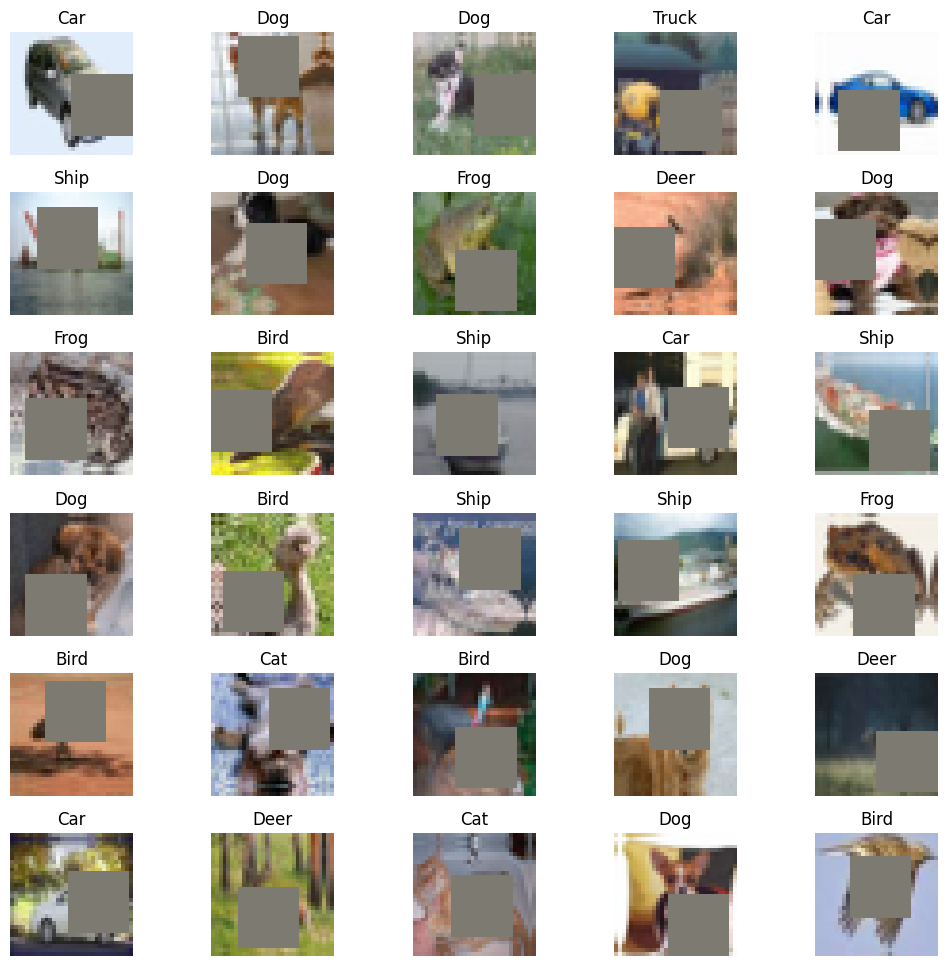

In [10]:
# Get a batch of training data from train_loader
batch_data, batch_label = next(iter(train_loader))

# Plot 30 sample images from the training data along with their labels
# plot_sample_training_images() imported from utils.py
fig, axs = plot_sample_training_images(batch_data, batch_label, class_label=classes, num_images=30)
plt.show()

## Model Summary


In [11]:
# Define the model
# No need to send the model to device as we are using the LightningModule
model = Net()

# enable printing shape
model.print_shape = True

# # Print the model summary by specifying the input size
# summary(model, input_size=(3, 32, 32))
detailed_model_summary(model, input_size=(3, 32, 32))

# disable printing shape for cleaner test train output
model.print_shape = False

PrepLayer 
	 torch.Size([1, 64, 32, 32]) 

Layer 1, X 
	 torch.Size([1, 128, 16, 16]) 

Layer 1, R1 
	 torch.Size([1, 128, 16, 16]) 

Layer 1, X + R1 
	 torch.Size([1, 128, 16, 16]) 

Layer 2 
	 torch.Size([1, 256, 8, 8]) 

Layer 3, X 
	 torch.Size([1, 512, 4, 4]) 

Layer 3, R2 
	 torch.Size([1, 512, 4, 4]) 

Layer 3, X + R2 
	 torch.Size([1, 512, 4, 4]) 

Max Pooling 
	 torch.Size([1, 512, 1, 1]) 

Reshape before FC 
	 torch.Size([1, 512]) 

After FC 
	 torch.Size([1, 10]) 

Layer (type:depth-idx)                   Input Shape      Kernel Shape     Output Shape     Param #          Trainable
CustomResNet                             [1, 3, 32, 32]   --               [1, 10]          --               True
├─Sequential: 1-1                        [1, 3, 32, 32]   --               [1, 64, 32, 32]  --               True
│    └─Conv2d: 2-1                       [1, 3, 32, 32]   [3, 3]           [1, 64, 32, 32]  1,728            True
│    └─BatchNorm2d: 2-2                  [1, 64, 32, 32]  

## Train and Test


### Define Logger


In [12]:
# Define logger
# https://lightning.ai/docs/pytorch/stable/extensions/generated/lightning.pytorch.loggers.TensorBoardLogger.html
logger = TensorBoardLogger(save_dir=logging_path, name="lightning_logs", log_graph=False)
# logger = CSVLogger(save_dir=logging_path, name="lightning_logs")

### Train and test model


/usr/local/lib/python3.10/dist-packages/lightning_fabric/connector.py:554: UserWarning: 16 is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!
  rank_zero_warn(
INFO:pytorch_lightning.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs




Batch size: 512, Total epochs: 24




  0%|          | 0/100 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 9.70E-02


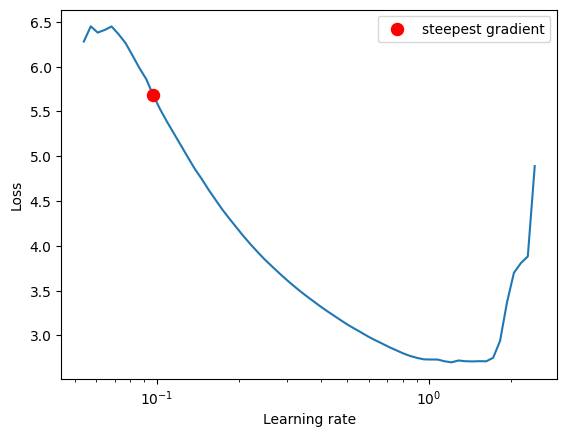

Suggested Max LR: 0.0970049125561403
Files already downloaded and verified
Files already downloaded and verified


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:Loading `train_dataloader` to estimate number of stepping batches.
INFO:pytorch_lightning.callbacks.model_summary:
  | Name              | Type               | Params
---------------------------------------------------------
0 | loss_function     | CrossEntropyLoss   | 0     
1 | accuracy_function | MulticlassAccuracy | 0     
2 | prep              | Sequential         | 1.9 K 
3 | layer1_x          | Sequential         | 74.0 K
4 | layer1_r1         | Sequential         | 295 K 
5 | layer2            | Sequential         | 295 K 
6 | layer3_x          | Sequential         | 1.2 M 
7 | layer3_r2         | Sequential         | 4.7 M 
8 | maxpool           | MaxPool2d          | 0     
9 | fc                | Linear             | 5.1 K 
---------------------------------------------------------
6.6 M     Trainable params
0         Non-trainable params
6.6 M     Tot

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=24` reached.


Files already downloaded and verified
Files already downloaded and verified


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc                   89.25
        test_loss           0.32490965723991394
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Results Length: 6
Misclassified Images Length: 3


In [13]:
# Create a dictionary of lists for misclassified images, generated predictions and ground truth
misclassified_image_data = {"images": [], "ground_truths": [], "predicted_vals": []}

# Run the model for num_epochs
trainer, results, misclassified_image_data = train_and_test_model(
    batch_size=batch_size,
    num_epochs=num_epochs,
    model=model,
    datamodule=cifar_data_module,
    logger=logger,
    # Alert: Change this when running in production
    debug=False,
)

## Metrics

In [19]:
# print(type(results))
# print(results)
# print(results.keys())
# print(results["train_loss"])

{'train_loss': [1.8655954599380493, 1.6999785900115967, 1.1958889961242676, 1.0329667329788208, 0.9878658056259155, 0.9526656270027161, 0.9059034585952759, 0.8736621141433716, 0.8511776328086853, 0.8216021060943604, 0.7915135025978088, 0.7822749018669128, 0.7562552094459534, 0.7328885793685913, 0.701874315738678, 0.6782264113426208, 0.6525306105613708, 0.6359767317771912, 0.6043002605438232, 0.5745657086372375, 0.5250145196914673, 0.4854639768600464, 0.4320112466812134, 0.3759470582008362], 'train_acc': [36.09400177001953, 44.178001403808594, 57.869998931884766, 63.20399856567383, 65.41999816894531, 66.44999694824219, 68.25, 69.38400268554688, 70.22799682617188, 71.39399719238281, 72.37799835205078, 72.51200103759766, 73.5199966430664, 74.35199737548828, 75.33599853515625, 76.16600036621094, 77.06199645996094, 77.66799926757812, 78.66400146484375, 79.9020004272461, 81.61000061035156, 83.02999877929688, 84.90799713134766, 86.69999694824219], 'test_loss': [0.32490965723991394], 'test_acc

Plotting accuracy and loss graphs.


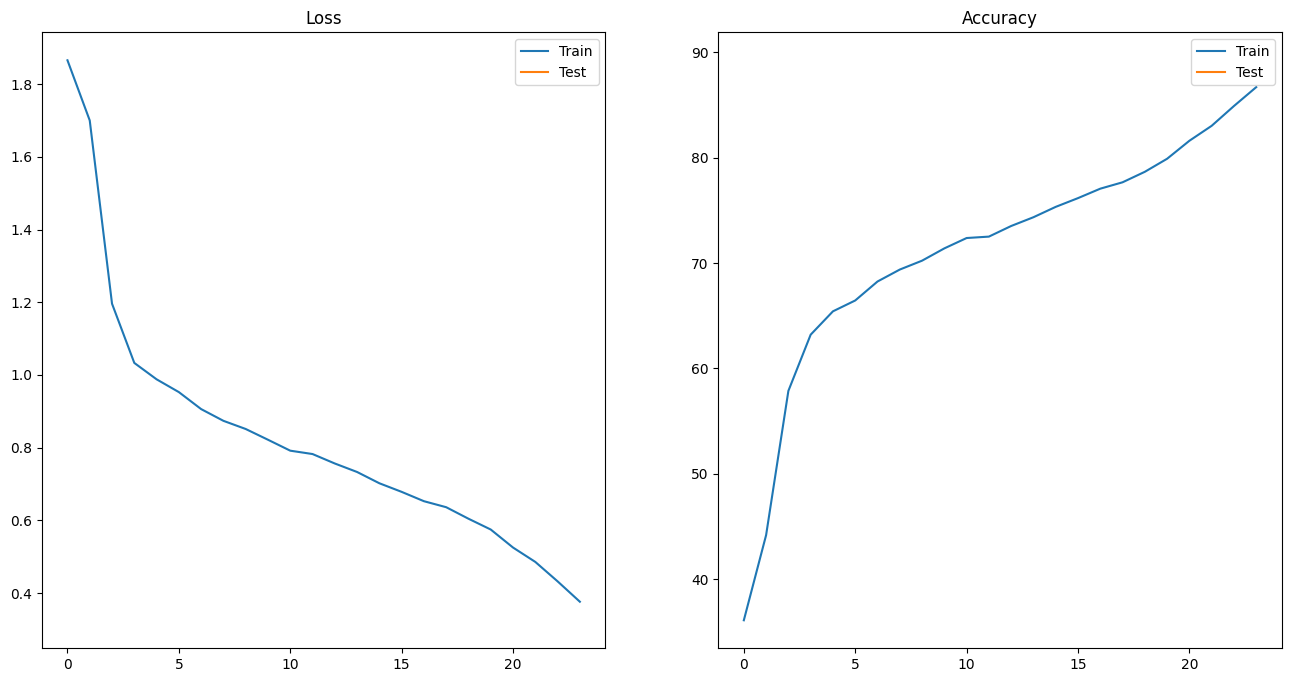

In [16]:
# Plot the accuracy and loss graphs using data and plot_train_test_metrics() from model.py
print("Plotting accuracy and loss graphs.")
fig, axs = plot_train_test_metrics(results)
plt.show()
# plt.savefig("Loss and Accuracy Metrics.png")

In [ ]:
# Pretty print train and test accuracy and loss values for each epoch
pretty_print_metrics(num_epochs=NUM_EPOCHS, results=results)

## Show Misclassified images


In [20]:
# print(type(misclassified_image_data))
# print(len(misclassified_image_data))
# print(misclassified_image_data.keys())
# print(misclassified_image_data["ground_truths"])

<class 'dict'>
3
dict_keys(['images', 'ground_truths', 'predicted_vals'])
[]


In [18]:
# Plot misclassified images
fig, axs = plot_misclassified_images(data=misclassified_image_data, class_label=classes, num_images=10)
plt.show()
# plt.savefig("Misclassified Images.png")

ValueError: ignored

<Figure size 1000x0 with 0 Axes>

## GradCAM (Misclassified)


In [ ]:
# Plot misclassified images
fig, axs = plot_gradcam_images(
    model=model,
    data=misclassified_image_data,
    class_label=classes,
    # Use penultimate block of resnet18 layer 3 as the target layer for gradcam
    # Decided using model summary so that dimensions > 7x7
    target_layers=[model.layer3_r2[-1]],
    targets=None,
    num_images=10,
    image_weight=0.1,
)
plt.show()
# plt.savefig("GradCAM Images.png")

## Logs


In [ ]:
# Using trainer and tensorboard logger, show the model metrics in tensorboard
%load_ext tensorboard

!tensorboard --logdir {logging_path}

2023-08-07 17:34:40.578191: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT

NOTE: Using experimental fast data loading logic. To disable, pass
    "--load_fast=false" and report issues on GitHub. More details:
    https://github.com/tensorflow/tensorboard/issues/4784

Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.12.3 at http://localhost:6006/ (Press CTRL+C to quit)
^C
